**Master IASD 2025**

Deep Learning for Image Analisis

**Generative Model by Denoising Score Networks**

Practical Session: Nov 7-2025

You should submit the notebook with the answers be email before the deadline.

Deadline: Nov 14-2025

Santiago VELASCO-FORERO santiago.velasco@minesparis.psl.eu

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import math
import numpy as np

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print('Code is running in a '+ device)

#Learning rate for the experiments
lr=1e-3

# 2D Mixture of Gaussians
pi1, pi2 = 0.5, 0.5
mu1 = torch.tensor([-2.0, 1.0])
mu2 = torch.tensor([2.0, 1.0])
cov1 = torch.tensor([[3, 0.0], [0.0, .1]])
cov2 = torch.tensor([[.1, 0.0], [0.0, 3]])

inv_cov1 = torch.inverse(cov1)
inv_cov2 = torch.inverse(cov2)
det_cov1 = torch.det(cov1)
det_cov2 = torch.det(cov2)

def gaussian_pdf(x, mu, cov, inv_cov, det_cov):
    diff = x - mu
    exponent = -0.5 * torch.sum(diff @ inv_cov * diff, dim=1)
    norm = 1.0 / (2 * torch.pi * torch.sqrt(det_cov))
    return norm * torch.exp(exponent)

def true_score(x):
    # p1(x), p2(x)
    p1 = gaussian_pdf(x, mu1, cov1, inv_cov1, det_cov1)
    p2 = gaussian_pdf(x, mu2, cov2, inv_cov2, det_cov2)

    # total mixture density
    p = pi1 * p1 + pi2 * p2 + 1e-12  # avoid division by zero

    # responsibilities
    r1 = pi1 * p1 / p
    r2 = pi2 * p2 / p

    # score for each Gaussian
    score1 = - (x - mu1) @ inv_cov1.T
    score2 = - (x - mu2) @ inv_cov2.T

    # weighted average (responsibility-weighted)
    score = r1.unsqueeze(1) * score1 + r2.unsqueeze(1) * score2
    return score


def sample_mog2d(n):
    #Generate n1 samples from  a standard normal distribution in 2D (Z), \Sigma=L^T L.
    #then X=Z L^T + mu follows  N(\mu,\Sigma)$
    mix = torch.rand(n) < pi1
    x = torch.zeros(n, 2)
    labels = torch.zeros(n, dtype=torch.long)
    n1, n2 = mix.sum(), (~mix).sum()
    x[mix] = torch.randn(n1, 2) @ torch.linalg.cholesky(cov1).T + mu1
    x[~mix] = torch.randn(n2, 2) @ torch.linalg.cholesky(cov2).T + mu2
    labels[~mix] = 1  # component 2
    return x,labels

Code is running in a cpu


In [3]:
def visualization_score(model,only_true=False):
  #This code visualize the 2D prediction of the model as a field.

  # Create a 2D grid for visualization
  x_vals = np.linspace(-5, 5, 30)
  y_vals = np.linspace(-5, 5, 30)
  X, Y = np.meshgrid(x_vals, y_vals)
  grid = torch.tensor(np.stack([X.flatten(), Y.flatten()], axis=1), dtype=torch.float32)

  # Compute true score
  score_true_grid = true_score(grid).numpy()
  U_true = score_true_grid[:,0].reshape(X.shape)
  V_true = score_true_grid[:,1].reshape(Y.shape)

  # Compute learned score
  with torch.no_grad():
      score_learned_grid = model(grid).numpy()
  U_learned = score_learned_grid[:,0].reshape(X.shape)
  V_learned = score_learned_grid[:,1].reshape(Y.shape)

  # Plot true score
  plt.figure(figsize=(12,5))
  plt.subplot(1,2,1)
  plt.quiver(X, Y, U_true, V_true, color='r')
  plt.title("True Score Field")
  plt.xlabel("x")
  plt.ylabel("y")
  plt.xlim(-5,5)
  plt.ylim(-5,5)

  if only_true:
    return U_learned,V_learned
  else:
    # Plot learned score
    plt.subplot(1,2,2)
    plt.quiver(X, Y, U_learned, V_learned, color='b')
    plt.title("Learned Score Field")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim(-5,5)
    plt.ylim(-5,5)
  plt.tight_layout()
  plt.show()
  return U_learned,V_learned

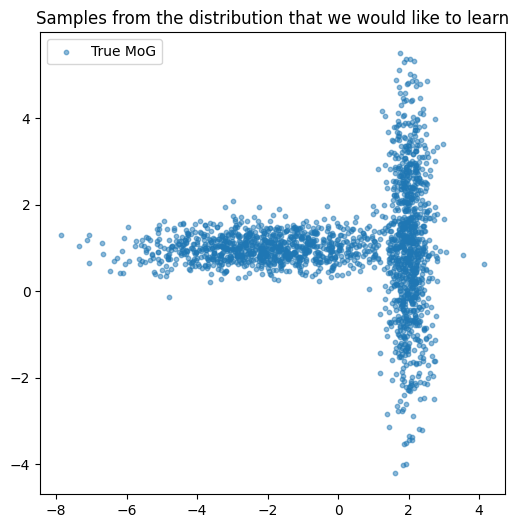

In [4]:
x_true, y_true = sample_mog2d(2000)

plt.figure(figsize=(6,6))
plt.scatter(x_true[:,0], x_true[:,1], alpha=0.5, label="True MoG", s=10)
plt.title("Samples from the distribution that we would like to learn")
plt.legend()
plt.show()


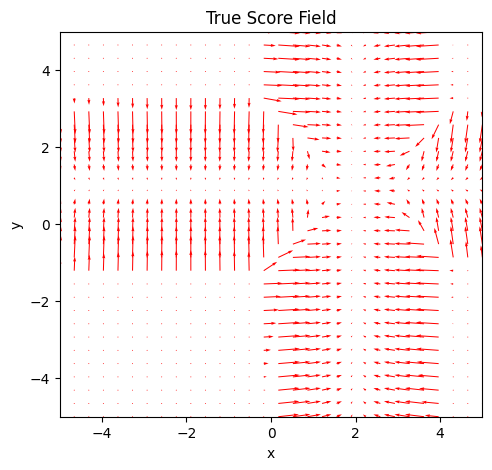

In [5]:
U,V=visualization_score(true_score,only_true=True)


##Dynamics Sampling

Langevin dynamics is a stochastic process that combines *gradient ascent*
on the log-probability with random noise.

The continuous form:

$dx_t = \frac{1}{2} \nabla_x \log p(x_t)\,dt + dW_t$

The discretized update used in sampling:

$x_{t+1} = x_t + \frac{\epsilon}{2}\nabla_x \log p(x_t) + \sqrt{\epsilon}\,z_t, \quad z_t\sim N(0,I)$

Intuition:

- Gradient term: moves points toward high-probability regions  
- Noise term: keeps exploration

In this case, the score is estimated by the model.

In [6]:
def langevin_sampling_2d(model, n_samples=2000, n_steps=300, eps=0.02):
  """
    Langevin sampling in 2D.

    model: a callable that takes x -> score(x) (torch.Tensor -> torch.Tensor of shape [n_samples, 2])
    n_samples: number of particles
    n_steps: total Langevin steps
    eps: step size
  """

  x = torch.randn(n_samples, 2)  # init from standard normal
  for t in range(n_steps):
    with torch.no_grad():
      score = model(x)
    noise = torch.randn_like(x)
    x = x + 0.5 * eps * score + torch.sqrt(torch.tensor(eps)) * noise
  return x



def langevin_sampling_2d_with_trajectory (model, n_samples=2000, n_steps=300, eps=0.02, record_every=5, n_traj_to_plot=100):
    """
    Langevin sampling in 2D with trajectory recording and visualization.

    model: a callable that takes x -> score(x) (torch.Tensor -> torch.Tensor of shape [n_samples, 2])
    n_samples: number of particles
    n_steps: total Langevin steps
    eps: step size
    record_every: how often to record intermediate positions (for plotting)
    n_traj_to_plot: number of trajectories to visualize
    """
    x = torch.randn(n_samples, 2)  # initialize from standard normal
    traj = [x.clone()]       # store initial positions

    for t in range(n_steps):
        with torch.no_grad():
            score = model(x)
        noise = torch.randn_like(x)
        x = x + 0.5 * eps * score + torch.sqrt(torch.tensor(eps)) * noise

        if (t + 1) % record_every == 0:
            traj.append(x.clone())

    traj = torch.stack(traj)  # shape (n_records, n_samples, 2)

    # ---- Visualization ----
    plt.figure(figsize=(8, 8))

    # Plot trajectories for a subset
    n_plot = min(traj.shape[1], n_traj_to_plot)
    for i in range(n_plot):
        plt.plot(traj[:, i, 0], traj[:, i, 1], lw=0.5, alpha=0.3, color='gray')

    # Start and end points
    plt.scatter(traj[0, :n_plot, 0], traj[0, :n_plot, 1], color='blue', s=10, label='start (x₀)')
    plt.scatter(x[:n_plot, 0], x[:n_plot, 1], color='orange', s=10, label='end ($x_T$)')

    plt.title("Langevin Sampling Trajectories (2D)")
    plt.xlabel("x₁")
    plt.ylabel("x₂")
    plt.legend()
    plt.axis('equal')
    plt.show()
    return x, traj

Q1. Write the functions euler_sampling_2d and euler_sampling_2d_with_trajectory as langevin_sampling without the stochastic component.

In [7]:
def euler_sampling_2d(model, n_samples=2000, n_steps=300, eps=0.02):
  """
    Euler sampling in 2D.

    model: a callable that takes x -> score(x) (torch.Tensor -> torch.Tensor of shape [n_samples, 2])
    n_samples: number of particles
    n_steps: total Langevin steps
    eps: step size
  """

  x = torch.randn(n_samples, 2)  # init from standard normal
  for t in range(n_steps):
    with torch.no_grad():
      score = model(x)
    x =  x + 0.5 * eps * score
  return x

def euler_sampling_2d_with_trajectory (model, n_samples=2000, n_steps=300, eps=0.02, record_every=5, n_traj_to_plot=100):
    """
    Langevin sampling in 2D with trajectory recording and visualization.

    model: a callable that takes x -> score(x) (torch.Tensor -> torch.Tensor of shape [n_samples, 2])
    n_samples: number of particles
    n_steps: total Langevin steps
    eps: step size
    record_every: how often to record intermediate positions (for plotting)
    n_traj_to_plot: number of trajectories to visualize
    """
    x = torch.randn(n_samples, 2)  # initialize from standard normal
    traj = [x.clone()]       # store initial positions

    for t in range(n_steps):
        with torch.no_grad():
            score = model(x)
        x =  x + 0.5 * eps * score

        if (t + 1) % record_every == 0:
            traj.append(x.clone())

    traj = torch.stack(traj)  # shape (n_records, n_samples, 2)

    # ---- Visualization ----
    plt.figure(figsize=(8, 8))

    # Plot trajectories for a subset
    n_plot = min(traj.shape[1], n_traj_to_plot)
    for i in range(n_plot):
        plt.plot(traj[:, i, 0], traj[:, i, 1], lw=0.5, alpha=0.3, color='gray')

    # Start and end points
    plt.scatter(traj[0, :n_plot, 0], traj[0, :n_plot, 1], color='blue', s=10, label='start (x₀)')
    plt.scatter(x[:n_plot, 0], x[:n_plot, 1], color='orange', s=10, label='end ($x_T$)')

    plt.title("Euler Sampling Trajectories (2D)")
    plt.xlabel("x₁")
    plt.ylabel("x₂")
    plt.legend()
    plt.axis('equal')
    plt.show()
    return x, traj

The results of Langevin sampling in the case where the score function is known are presented below.

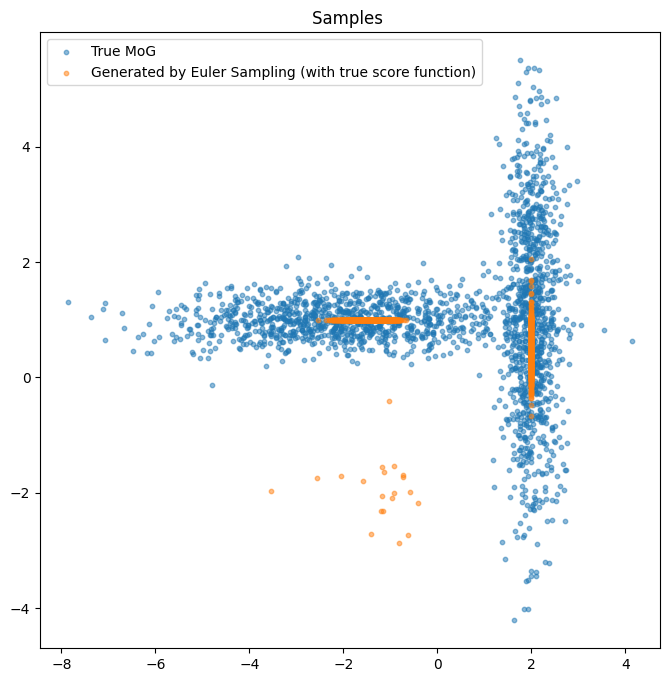

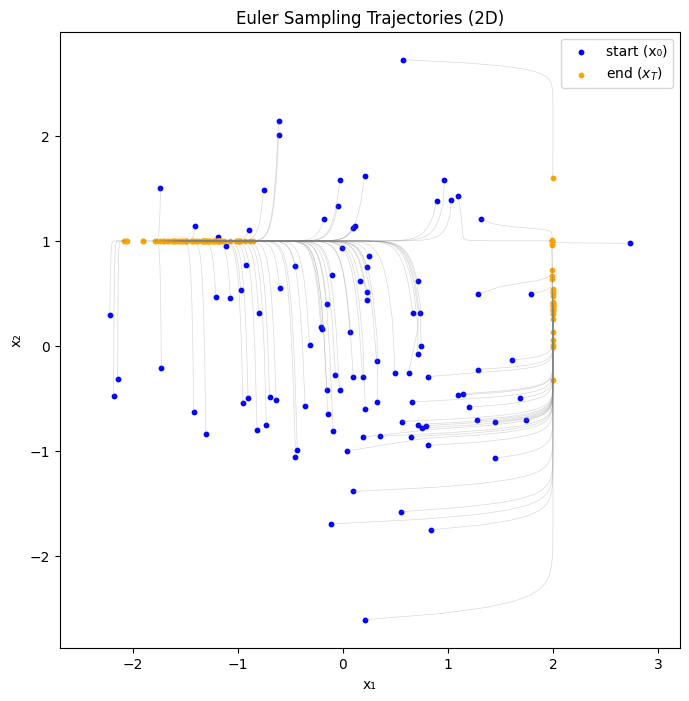

In [8]:
samples = euler_sampling_2d(true_score)
plt.figure(figsize=(8,8))
plt.scatter(x_true[:,0], x_true[:,1], alpha=0.5, label="True MoG", s=10)
plt.scatter(samples[:,0], samples[:,1], alpha=0.5, label="Generated by Euler Sampling (with true score function)", s=10)
plt.title("Samples ")
plt.legend()
plt.show()

samples, traj = euler_sampling_2d_with_trajectory(true_score,n_traj_to_plot=100)

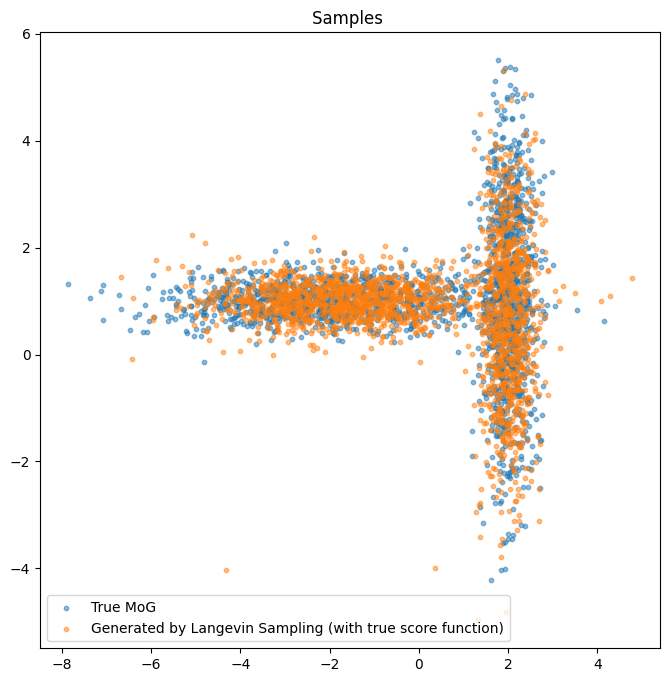

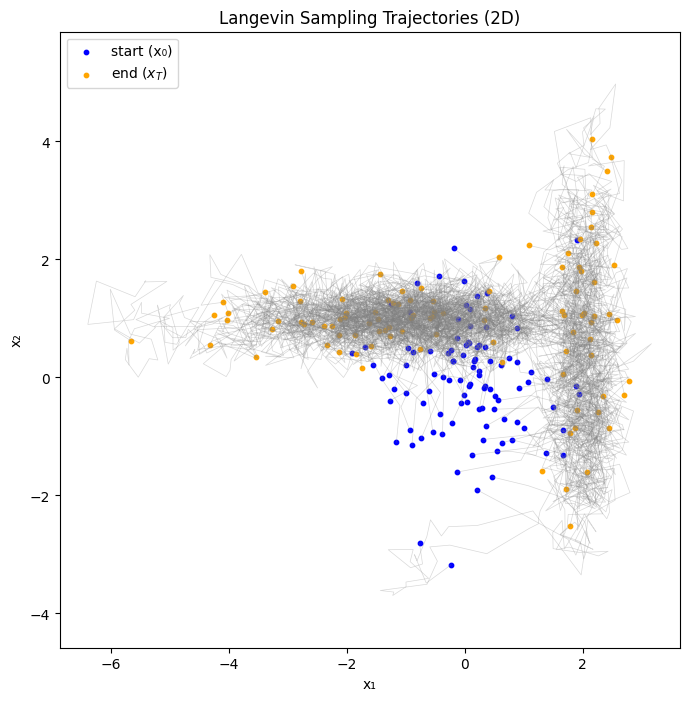

In [9]:
samples = langevin_sampling_2d(true_score)

plt.figure(figsize=(8,8))
plt.scatter(x_true[:,0], x_true[:,1], alpha=0.5, label="True MoG", s=10)
plt.scatter(samples[:,0], samples[:,1], alpha=0.5, label="Generated by Langevin Sampling (with true score function)", s=10)
plt.title("Samples ")
plt.legend()
plt.show()

samples, traj = langevin_sampling_2d_with_trajectory(true_score)

We created a model to estimate the score function.

In [10]:
class ScoreNet2D(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 2)
        )
    def forward(self, x):
        return self.net(x)


In [11]:
model_Score = ScoreNet2D().to(device)
optimizer = optim.Adam(model_Score.parameters(), lr=lr)

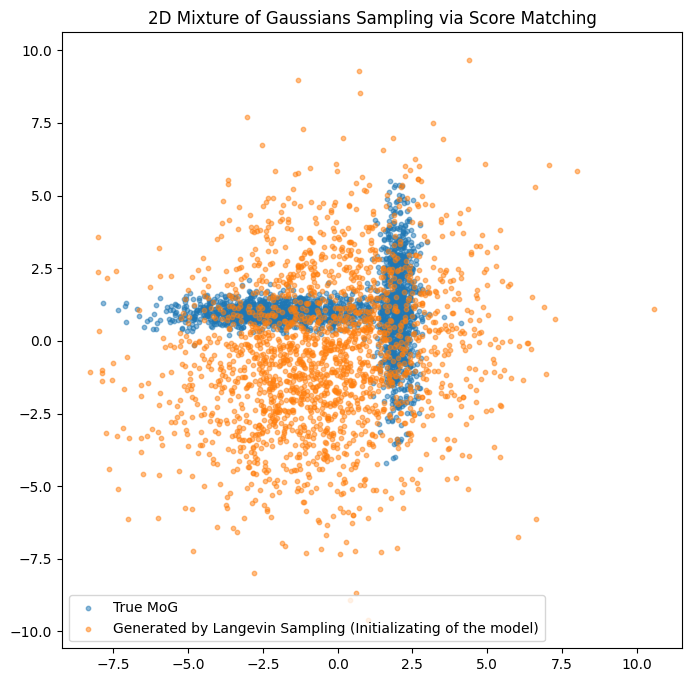

In [12]:
# True vs generated samples (scatter plot)
samples = langevin_sampling_2d(model_Score)

plt.figure(figsize=(8,8))
plt.scatter(x_true[:,0], x_true[:,1], alpha=0.5, label="True MoG", s=10)
plt.scatter(samples[:,0], samples[:,1], alpha=0.5, label="Generated by Langevin Sampling (Initializating of the model)", s=10)
plt.title("2D Mixture of Gaussians Sampling via Score Matching")
plt.legend()
plt.show()


#samples, traj = langevin_sampling_2d_with_trajectory(model_Score)



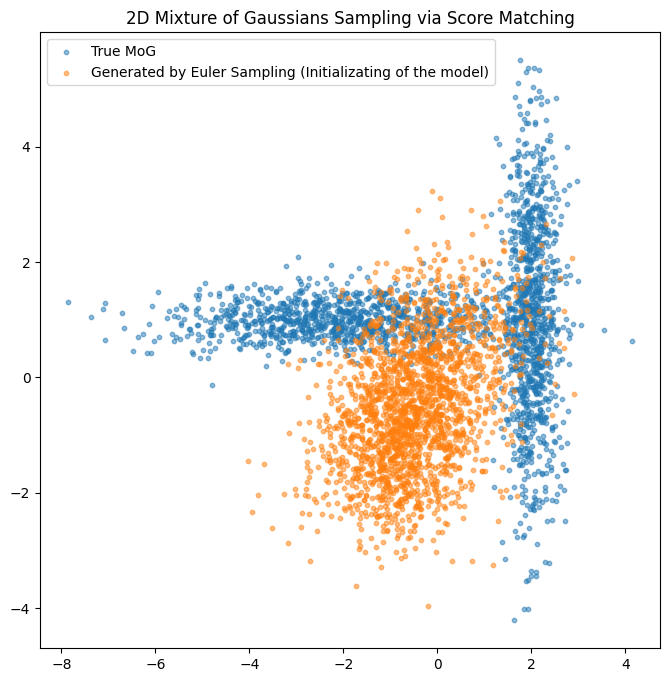

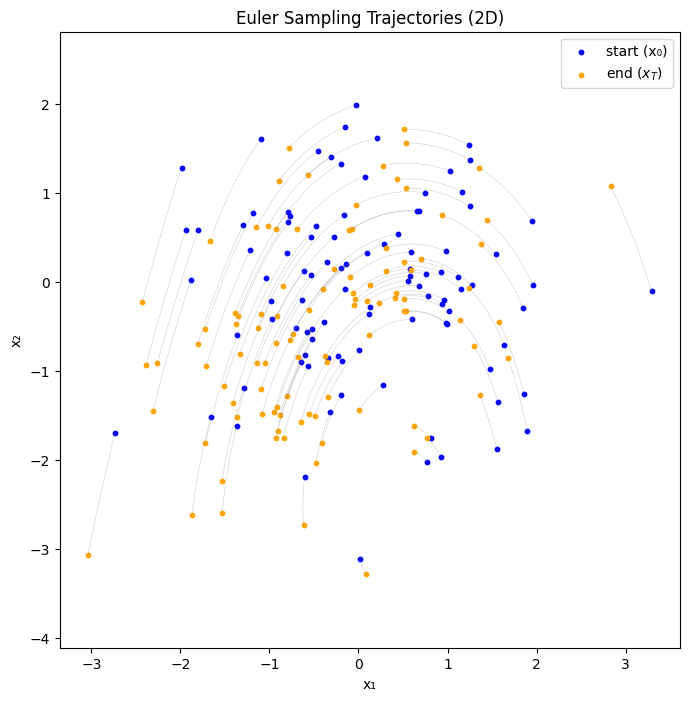

In [13]:
samples = euler_sampling_2d(model_Score)

plt.figure(figsize=(8,8))
plt.scatter(x_true[:,0], x_true[:,1], alpha=0.5, label="True MoG", s=10)
plt.scatter(samples[:,0], samples[:,1], alpha=0.5, label="Generated by Euler Sampling (Initializating of the model)", s=10)
plt.title("2D Mixture of Gaussians Sampling via Score Matching")
plt.legend()
plt.show()


samples, traj = euler_sampling_2d_with_trajectory(model_Score,n_samples=10000)


In [14]:
epochs = 3000
batch_size = 512
sigma = 0.5  # noise level
losses = []

Training for a denoising score-matching (DSM) model:


We want to train a neural network model(x) to approximate the score function:
$
s_{\theta}(x)≈ ∇_x log p_{data}(x)
$

However, in general cases, the directly computing that gradient from samples is impossible, because we only have data samples from $p_{data}(x)$.

Accordingly, denoising score matching (DSM) corrupts data with noise, and teach the model to predict how to remove that noise.

In [15]:
for epoch in range(epochs):
    x,y = sample_mog2d(batch_size)
    noise = torch.randn_like(x) * sigma
    x_tilde = x + noise

    target = - noise / (sigma**2)  # denoising target
    score_pred = model_Score(x_tilde)

    loss = 0.5 * torch.mean((score_pred - target)**2)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    if (epoch+1) % 500 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] Loss: {loss.item():.4f}")

Epoch [500/3000] Loss: 1.4694
Epoch [1000/3000] Loss: 1.3172
Epoch [1500/3000] Loss: 1.4123
Epoch [2000/3000] Loss: 1.3713
Epoch [2500/3000] Loss: 1.2256
Epoch [3000/3000] Loss: 1.3443


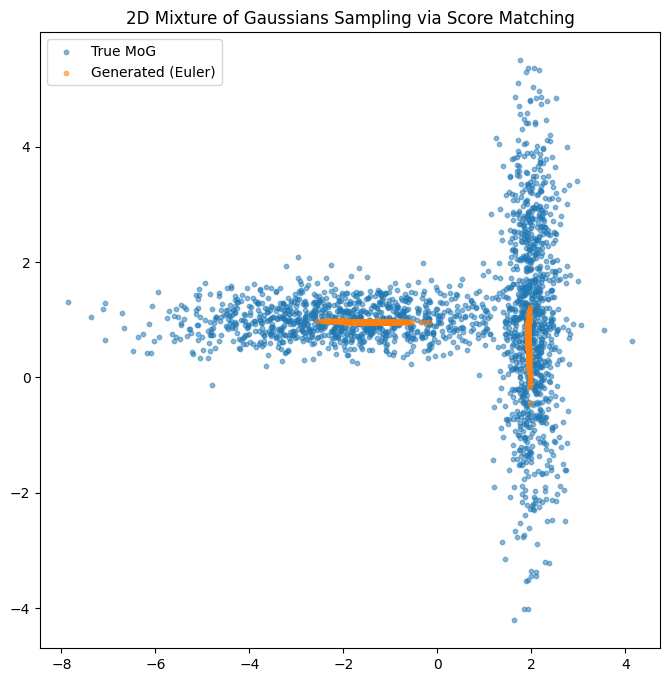

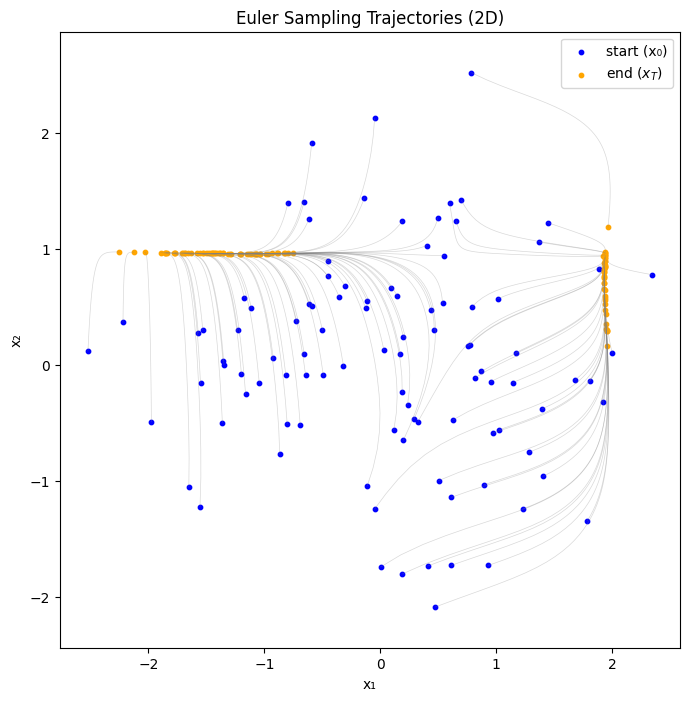

In [16]:
# True vs generated samples (scatter plot)
samples = euler_sampling_2d(model_Score)

plt.figure(figsize=(8,8))
plt.scatter(x_true[:,0], x_true[:,1], alpha=0.5, label="True MoG", s=10)
plt.scatter(samples[:,0], samples[:,1], alpha=0.5, label="Generated (Euler)", s=10)
plt.title("2D Mixture of Gaussians Sampling via Score Matching")
plt.legend()
plt.show()

samples, traj = euler_sampling_2d_with_trajectory(model_Score)

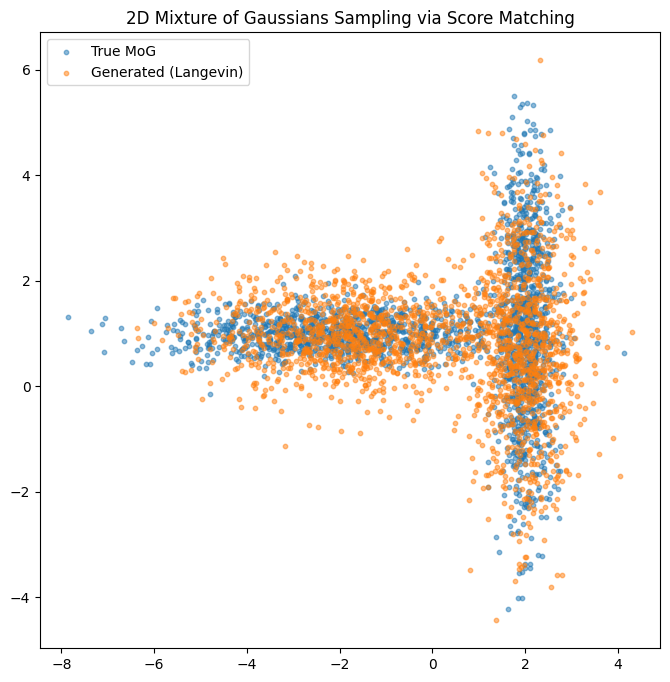

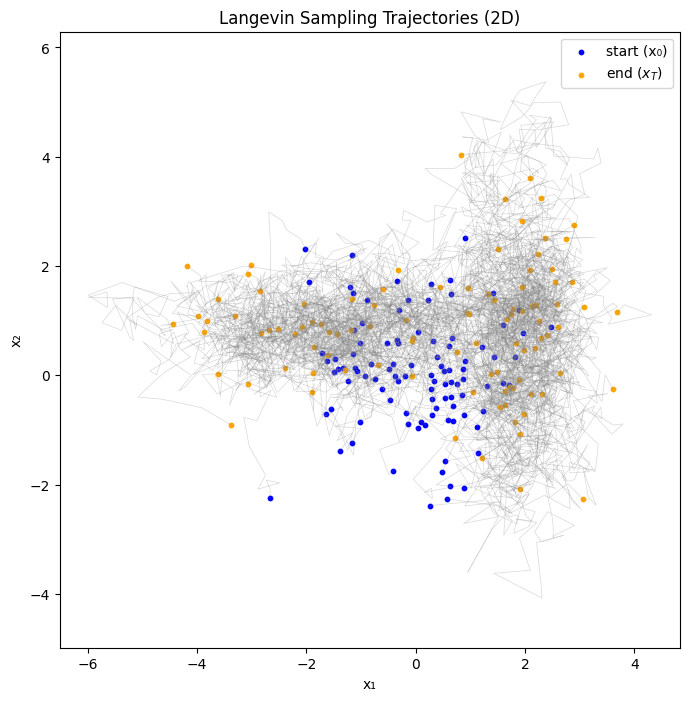

In [17]:
# True vs generated samples (scatter plot)
samples = langevin_sampling_2d(model_Score)

plt.figure(figsize=(8,8))
plt.scatter(x_true[:,0], x_true[:,1], alpha=0.5, label="True MoG", s=10)
plt.scatter(samples[:,0], samples[:,1], alpha=0.5, label="Generated (Langevin)", s=10)
plt.title("2D Mixture of Gaussians Sampling via Score Matching")
plt.legend()
plt.show()

samples, traj = langevin_sampling_2d_with_trajectory(model_Score)

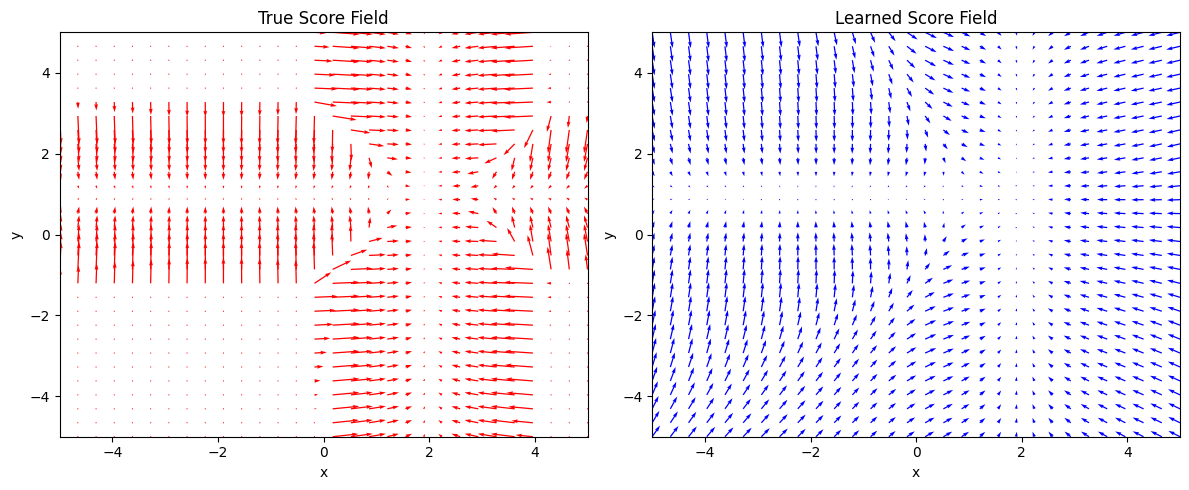

In [18]:
U,V=visualization_score(model_Score)

**Q2**:  Visualize the generation by langevin_sampling with epsilon=1e-5 and epsilon=1. What can you say about the effect of this generation parameter?

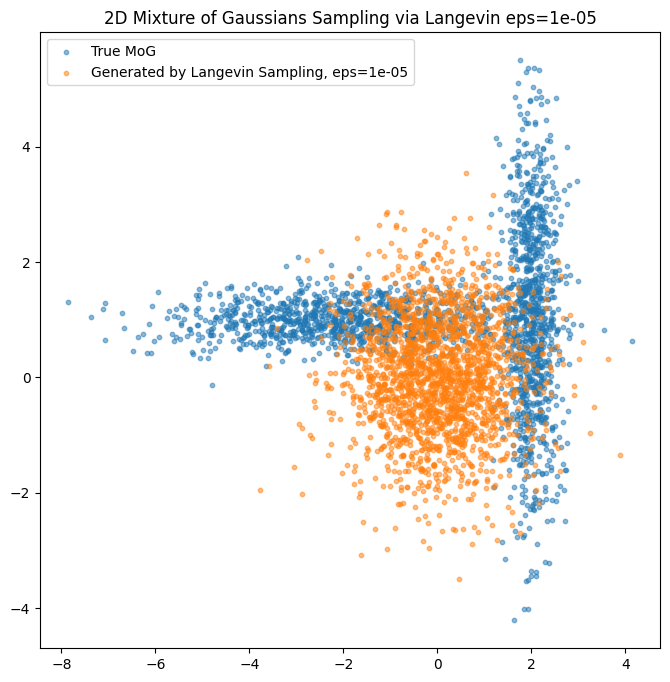

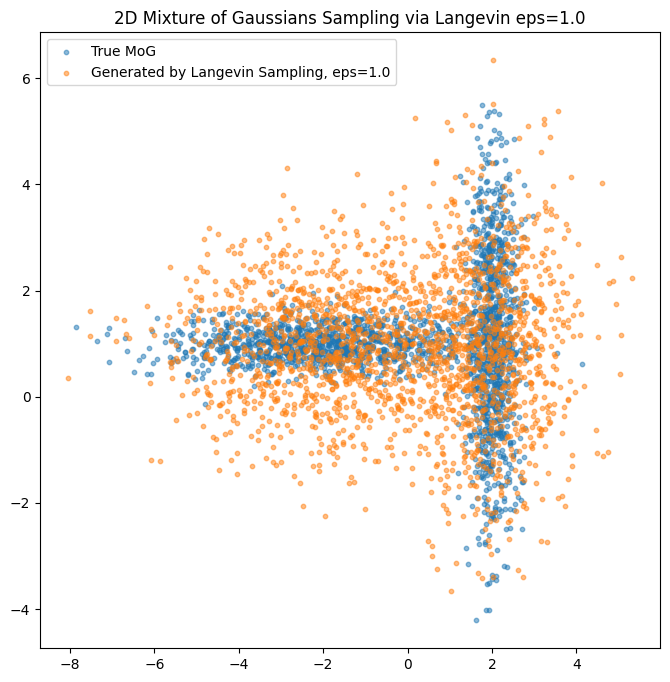

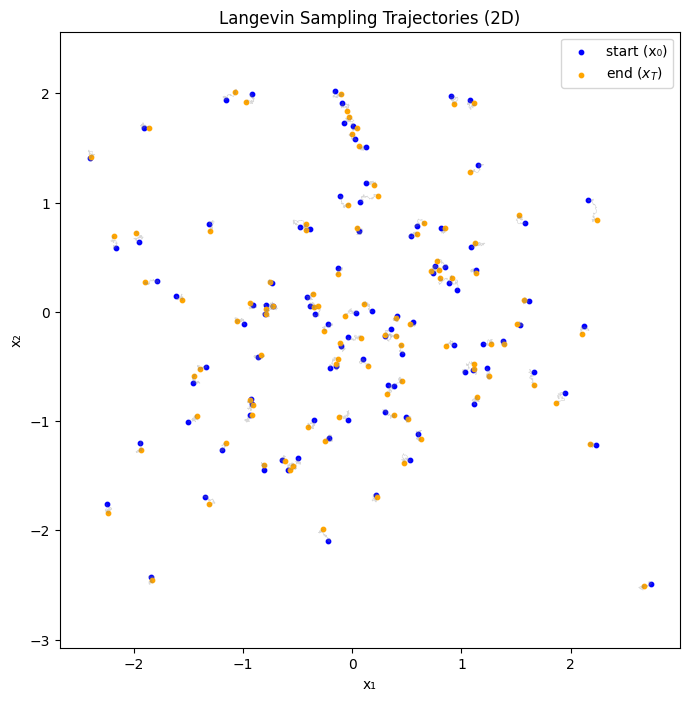

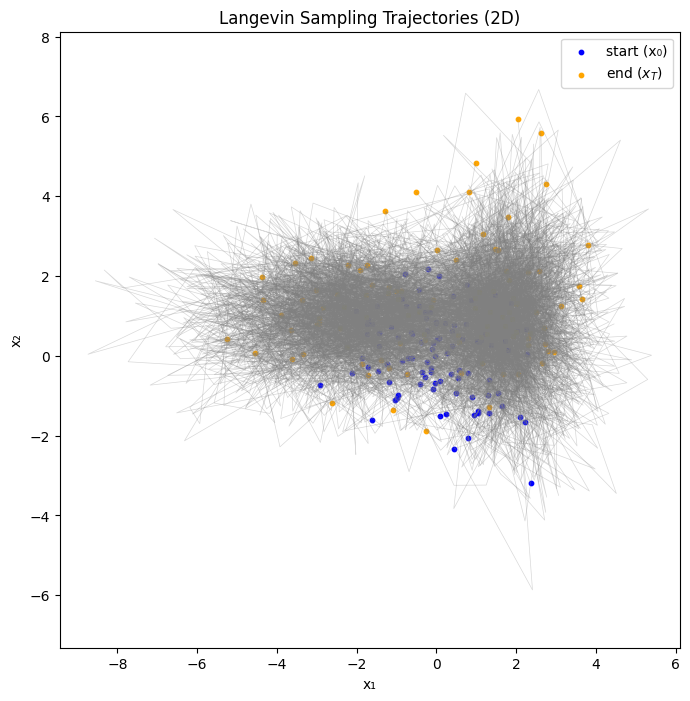

In [19]:
eps_values = [1e-5, 1.0]

for eps in eps_values:
    samples = langevin_sampling_2d(model_Score, n_samples=2000, n_steps=300, eps=eps)

    plt.figure(figsize=(8, 8))
    plt.scatter(x_true[:,0], x_true[:,1], alpha=0.5, label="True MoG", s=10)
    plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5, label=f"Generated by Langevin Sampling, eps={eps}", s=10)
    plt.title(f"2D Mixture of Gaussians Sampling via Langevin eps={eps}")
    plt.legend()
    plt.show()


for eps in eps_values:
    samples, traj = langevin_sampling_2d_with_trajectory(model_Score, eps=eps,)

### 1. When ɛ = 1e-5:

When ε is very small, the generated points stay close to the center and don't move toward the real data regions.
The trajectories also show only tiny movements.
This happens because in the update rule

$$
x_{t+1} = x_t + \frac{\varepsilon}{2}s_\theta(x_t) + \sqrt{\varepsilon}z_t
$$

the steps are extremely small, so both the movement and the noise almost disappear.
As a result, the sampler does not move and doesn't explore the data well.



### 2. When ɛ = 1.0:

When ε is too large, the generated points become messy and spread everywhere, and the real shape of the data disappears.
The samples make big, random jumps instead of moving smoothly toward the data.
Because both the movement and the noise are too strong, the sampler becomes unstable and goes off in wrong directions.So it explores too much and never settles down on the real data distribution.

So we need a moderate ɛ.

**Annealed Langevin Dynamics** (ALD) introduces a temperature (or noise) schedule to help the sampler explore the space more effectively.
It samples progressively from noisy to clean distributions: starting easy, then refining.

In [20]:
# --- Example MLP score network ---
class ScoreNetSigma(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim + 1, hidden_dim),  # +1 for sigma input
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )
    def forward(self, x, sigma):
      # x: [batch_size, 2]
      # sigma: scalar or tensor of shape [batch_size]

      if sigma.dim() == 0:  # scalar
          sigma_feature = sigma.expand(x.shape[0], 1)  # [batch_size,1]
      elif sigma.dim() == 1:  # already batch of sigmas
          sigma_feature = sigma.reshape(-1, 1)        # [batch_size,1]
      else:
          raise ValueError("sigma must be scalar or 1D tensor")

      inp = torch.cat([x, sigma_feature], dim=1)      # [batch_size, 3]
      return self.net(inp)

In [21]:
# --- Training hyperparameters ---
sigmas = torch.exp(torch.linspace(torch.log(torch.tensor(1.0)), torch.log(torch.tensor(0.05)), 10))
print(sigmas)


tensor([1.0000, 0.7169, 0.5139, 0.3684, 0.2641, 0.1893, 0.1357, 0.0973, 0.0697,
        0.0500])


In [22]:
model_ScoreSigma = ScoreNetSigma().to(device)
optimizer = optim.Adam(model_ScoreSigma.parameters(), lr=lr)
losses = []


In [23]:
# --- Training loop (annealed DSM) ---
for epoch in range(epochs):
    x,y = sample_mog2d(batch_size)

    # Sample a sigma for each sample from the schedule
    sigma = sigmas[torch.randint(0, len(sigmas), (batch_size,))].to(device)

    # Add Gaussian noise
    noise = torch.randn_like(x) * sigma.view(-1, 1)
    x_tilde = x + noise

    # Denoising target
    target = - noise / (sigma.view(-1,1)**2)

    # Forward pass
    score_pred = model_ScoreSigma(x_tilde, sigma)

    # MSE loss
    loss = 0.5 * torch.mean((score_pred - target)**2)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    if (epoch+1) % 500 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] Loss: {loss.item():.4f}")

Epoch [500/3000] Loss: 44.4403
Epoch [1000/3000] Loss: 39.9350
Epoch [1500/3000] Loss: 32.6486
Epoch [2000/3000] Loss: 42.4988
Epoch [2500/3000] Loss: 32.2932
Epoch [3000/3000] Loss: 40.0920


In [24]:
# --- Annealed Langevin dynamics sampler
def langevin_sampling_annealed(model, n_samples=1000, n_steps_each=50,
                               sigma_min=0.05, sigma_max=1.0, n_sigmas=10,
                               eps_coeff=0.1, device="cpu"):
    """
    Generate samples using annealed Langevin dynamics.
    model: score network s_theta(x, sigma)
    eps_coeff: step size = eps_coeff * sigma^2
    """
    # Log-spaced noise schedule
    sigmas = torch.exp(torch.linspace(torch.log(torch.tensor(sigma_max)),
                                      torch.log(torch.tensor(sigma_min)),
                                      n_sigmas)).to(device)

    # Initialize from Gaussian noise
    x = torch.randn(n_samples, 2, device=device) * sigma_max

    # Loop over noise levels
    for sigma in sigmas:
        eps = eps_coeff * sigma**2
        for _ in range(n_steps_each):
            z = torch.randn_like(x)
            with torch.no_grad():
              score = model(x, sigma)
            x = x + 0.5 * eps * score + torch.sqrt(eps) * z

    return x

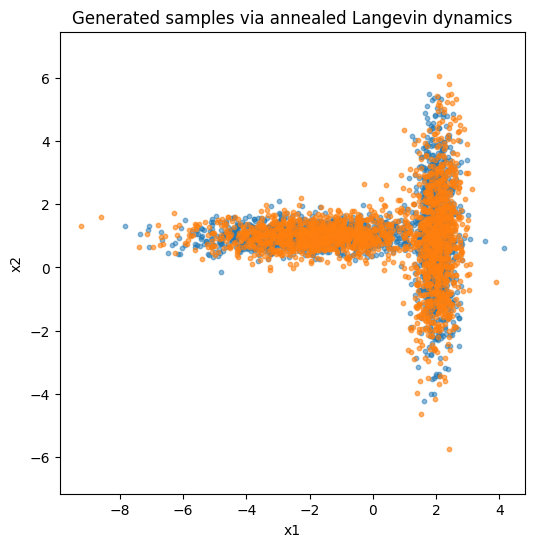

In [25]:
# Generate 2000 samples
samples = langevin_sampling_annealed(model_ScoreSigma, n_samples=2000, n_steps_each=50,
                                     sigma_min=0.05, sigma_max=1.0, n_sigmas=10,
                                     eps_coeff=0.1, device="cpu")

# Plot the generated 2D samples
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(x_true[:,0], x_true[:,1], alpha=0.5, label="True MoG", s=10)
plt.scatter(samples[:,0], samples[:,1], s=10, alpha=0.6)
plt.title("Generated samples via annealed Langevin dynamics")
plt.xlabel("x1")
plt.ylabel("x2")
plt.axis("equal")
plt.show()

**Q3**: Create a function to visualise the field of the score function for different values of sigma.

In [26]:
def visualization_score_annealed(model,sigma,only_true=False):
  #This code visualize the 2D prediction of the model as a field.
  # Create a 2D grid for visualization
  x_vals = np.linspace(-5, 5, 30)
  y_vals = np.linspace(-5, 5, 30)
  X, Y = np.meshgrid(x_vals, y_vals)
  grid = torch.tensor(np.stack([X.flatten(), Y.flatten()], axis=1), dtype=torch.float32)

  # Compute true score
  score_true_grid = true_score(grid).numpy()
  U_true = score_true_grid[:,0].reshape(X.shape)
  V_true = score_true_grid[:,1].reshape(Y.shape)

  # Compute learned score
  with torch.no_grad():
      score_learned_grid = model(grid.to(device), torch.tensor(sigma, dtype=torch.float32, device=device)).cpu().numpy()
  U_learned = score_learned_grid[:,0].reshape(X.shape)
  V_learned = score_learned_grid[:,1].reshape(Y.shape)

  # Plot true score
  plt.figure(figsize=(12,5))
  plt.subplot(1,2,1)
  plt.quiver(X, Y, U_true, V_true, color='r')
  plt.title("True Score Field")
  plt.xlabel("x")
  plt.ylabel("y")
  plt.xlim(-5,5)
  plt.ylim(-5,5)

  if only_true:
    return U_learned,V_learned
  else:
    # Plot learned score
    plt.subplot(1,2,2)
    plt.quiver(X, Y, U_learned, V_learned, color='b')
    plt.title("Learned Score Field (Sigma="+str(sigma)+")")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim(-5,5)
    plt.ylim(-5,5)
  plt.tight_layout()
  plt.show()
  return U_learned,V_learned

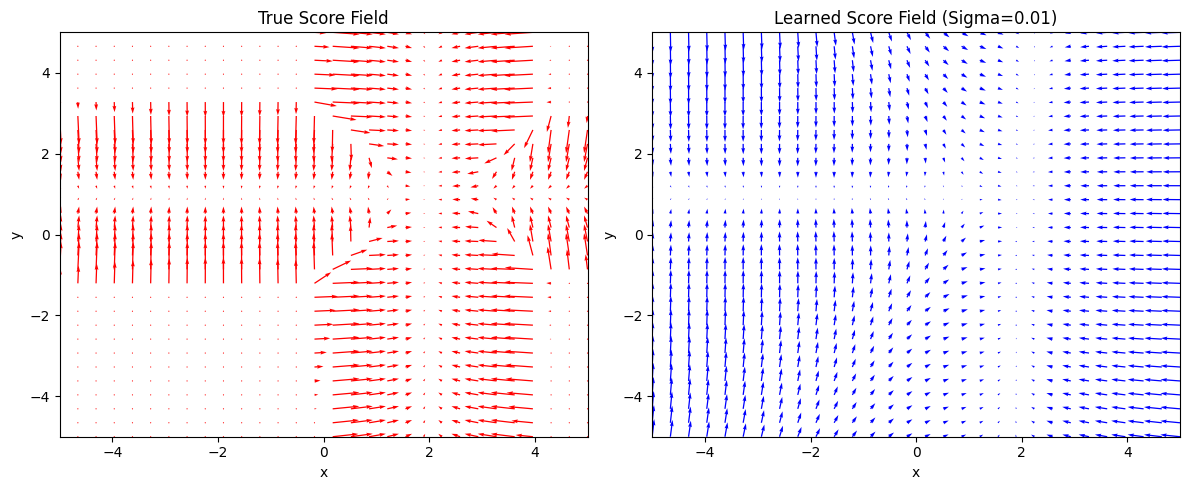

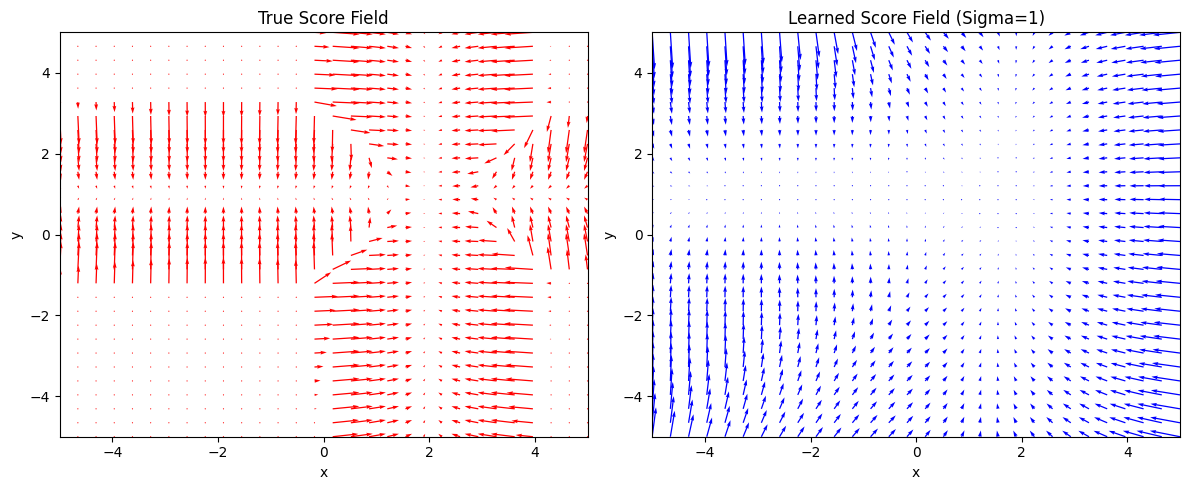

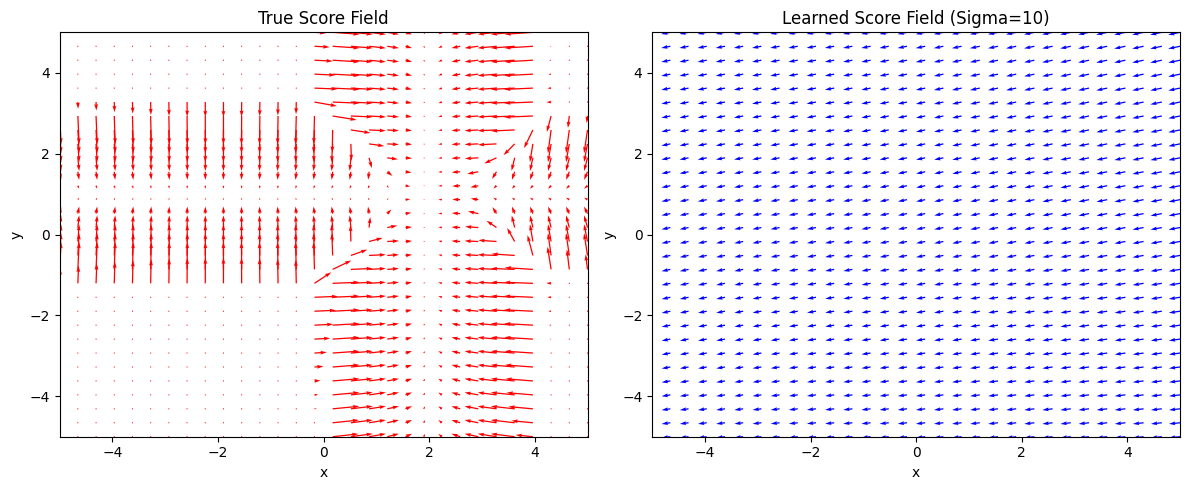

In [27]:
U,V=visualization_score_annealed(model_ScoreSigma,0.01)
U,V=visualization_score_annealed(model_ScoreSigma,1)
U,V=visualization_score_annealed(model_ScoreSigma,10)

**Q4**. Compare denoising score matching model generate by Langevin and Annealed Langevin using:


a. Maximum Mean Discrepancy for a Gaussian kernel with different value value of sigma (parameter of the kernel)

b. Wasserstein distance between generated and original data set. Use for instance (https://pythonot.github.io/)


c. Precision/Recall Curve (by varying k-value)

Precision: How many generated samples fall on near the true data "manifold"?
Recall: How much of the true data "manifold" is covered by the generated samples?
We approximate “on/near the manifold” using k-nearest neighbor distances.

###
1. Compute distance from each generated sample to its k-th nearest generated neighbor to get R_gen.

2. For each real sample, compute its distance to its k nearest generated neighbors.

3. If the distance to the k-th nearest generated neighbor $\leq R_gen$, we say the real sample is "covered by generated samples".

4. We use as "Recall" the fraction of real samples that are covered by the generated.

In the symmetric way, we define "Precision", the fraction of generated data that are covered by the real samples.

With that two measures, we can define a F1-score.

####


### Q4. a.

In [28]:
x_true, _ = sample_mog2d(2000)
x_true = x_true.numpy()

samples_langevin = langevin_sampling_2d(model_Score, n_samples=2000).detach().numpy()
samples_annealed = langevin_sampling_annealed(model_ScoreSigma, n_samples=2000).detach().cpu().numpy()

In [29]:
def gaussian_kernel_matrix(x, y, sigma):

    x = x[:, None, :]
    y = y[None, :, :]
    sqdist = np.sum((x - y)**2, axis=-1)
    return np.exp(-sqdist / (2 * sigma**2))

def mmd_gaussian(x, y, sigma):
    Kxx = gaussian_kernel_matrix(x, x, sigma)
    Kyy = gaussian_kernel_matrix(y, y, sigma)
    Kxy = gaussian_kernel_matrix(x, y, sigma)
    mmd2 = Kxx.mean() + Kyy.mean() - 2 * Kxy.mean()
    return np.sqrt(max(mmd2, 0.0))

kernel_sigmas = [0.1, 0.5, 1.0, 2.0]
for s in kernel_sigmas:
    mmd_l = mmd_gaussian(x_true, samples_langevin, sigma=s)
    mmd_a = mmd_gaussian(x_true, samples_annealed, sigma=s)
    print(f"sigma_k = {s:>3}:  Langevin = {mmd_l:.4f},  Annealed = {mmd_a:.4f}")


sigma_k = 0.1:  Langevin = 0.0437,  Annealed = 0.0318
sigma_k = 0.5:  Langevin = 0.0882,  Annealed = 0.0449
sigma_k = 1.0:  Langevin = 0.0804,  Annealed = 0.0435
sigma_k = 2.0:  Langevin = 0.0706,  Annealed = 0.0370


### b:

In [30]:
!pip install POT

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 18.7 MB/s eta 0:00:00


In [32]:
import ot

def wasserstein_distance(x, y):

    n, m = x.shape[0], y.shape[0]
    a = np.ones((n,)) / n
    b = np.ones((m,)) / m
    M = ot.dist(x, y, metric='euclidean')
    W = ot.emd2(a, b, M)
    return W

W_langevin = wasserstein_distance(x_true, samples_langevin)
W_annealed = wasserstein_distance(x_true, samples_annealed)

print(f"Wasserstein distance:")
print(f"Langevin vs data:  {W_langevin:.4f}")
print(f"Annealed vs data:  {W_annealed:.4f}")

Wasserstein distance:
Langevin vs data:  0.4127
Annealed vs data:  0.2056


### c:

In [33]:
def pairwise_distances(x, y):

    x = x[:, None, :]
    y = y[None, :, :]
    return np.linalg.norm(x - y, axis=-1)

def compute_prdc(real, fake, k=5):

    dist_real_real = pairwise_distances(real, real)
    np.fill_diagonal(dist_real_real, np.inf)
    real_radius = np.sort(dist_real_real, axis=1)[:, k-1]

    dist_fake_fake = pairwise_distances(fake, fake)
    np.fill_diagonal(dist_fake_fake, np.inf)
    fake_radius = np.sort(dist_fake_fake, axis=1)[:, k-1]

    # cross distances
    dist_real_fake = pairwise_distances(real, fake)
    dist_fake_real = dist_real_fake.T

    # Recall:
    covered_real = (dist_real_fake <= fake_radius[None, :]).any(axis=1)
    recall = covered_real.mean()

    # Precision:
    covered_fake = (dist_fake_real <= real_radius[None, :]).any(axis=1)
    precision = covered_fake.mean()

    if precision + recall > 0:
        f1 = 2 * precision * recall / (precision + recall)
    else:
        f1 = 0.0

    return precision, recall, f1

k_list = [1, 3, 5, 10]

print("Precision, Recall, F1 for Langevin:")
for k in k_list:
    p, r, f1 = compute_prdc(x_true, samples_langevin, k=k)
    print(f"k = {k:2d}: P = {p:.3f}, R = {r:.3f}, F1 = {f1:.3f}")

print("\nPrecision, Recall, F1 for Annealed Langevin:")
for k in k_list:
    p, r, f1 = compute_prdc(x_true, samples_annealed, k=k)
    print(f"k = {k:2d}: P = {p:.3f}, R = {r:.3f}, F1 = {f1:.3f}")


Precision, Recall, F1 for Langevin:
k =  1: P = 0.667, R = 0.711, F1 = 0.688
k =  3: P = 0.906, R = 0.984, F1 = 0.943
k =  5: P = 0.938, R = 0.999, F1 = 0.967
k = 10: P = 0.964, R = 1.000, F1 = 0.982

Precision, Recall, F1 for Annealed Langevin:
k =  1: P = 0.683, R = 0.707, F1 = 0.695
k =  3: P = 0.962, R = 0.979, F1 = 0.970
k =  5: P = 0.990, R = 0.996, F1 = 0.992
k = 10: P = 0.995, R = 0.999, F1 = 0.996


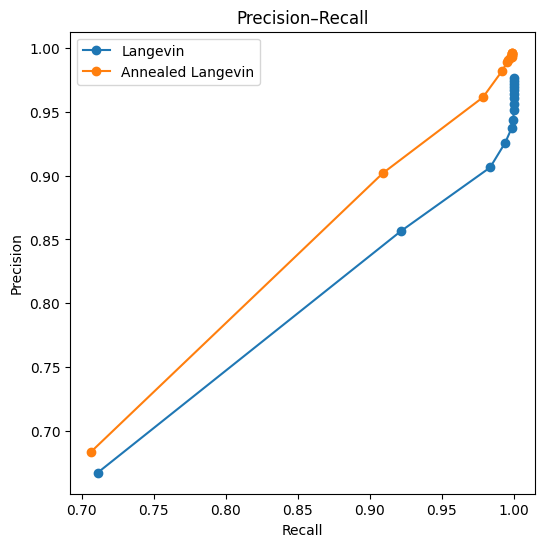

In [34]:
def plot_pr_curve(real, fake, label):
    ks = np.arange(1, 16)
    precisions, recalls, f1s = [], [], []
    for k in ks:
        p, r, f1 = compute_prdc(real, fake, k)
        precisions.append(p)
        recalls.append(r)
        f1s.append(f1)
    plt.plot(recalls, precisions, marker='o', label=label)

plt.figure(figsize=(6,6))
plot_pr_curve(x_true, samples_langevin, "Langevin")
plot_pr_curve(x_true, samples_annealed, "Annealed Langevin")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall")
plt.legend()
plt.show()

As you can see, the Annealed Langevin is better in all metrics.

**Q5**. Generate noisy version of the dataset 2D Mixture of Gaussians by adding Gaussian noise at three different levels: small, medium, and large.

For each noise level, compute the precision, recall, and F1 score between the real data (x_real) and the noisy samples using k-NN evaluation.
Vary the number of neighbors k from 1 to 20, plot the resulting curves for each noise level, and explain how noise affects the precision, recall, and F1 metrics.

In [35]:
x_real, _ = sample_mog2d(2000)
x_real = x_real.numpy()

sigma_small  = 0.1
sigma_medium = 0.5
sigma_large  = 1.0

noisy_small  = x_real + np.random.randn(*x_real.shape) * sigma_small
noisy_medium = x_real + np.random.randn(*x_real.shape) * sigma_medium
noisy_large  = x_real + np.random.randn(*x_real.shape) * sigma_large

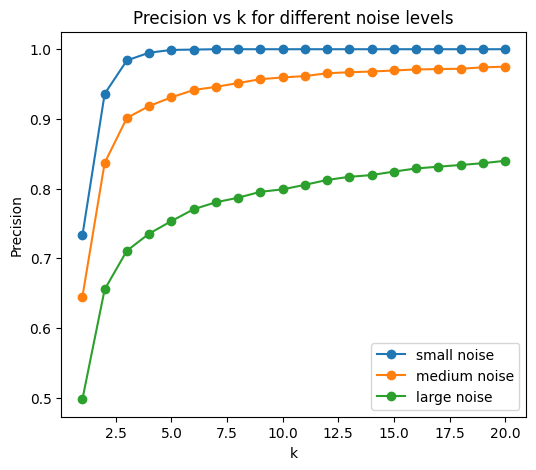

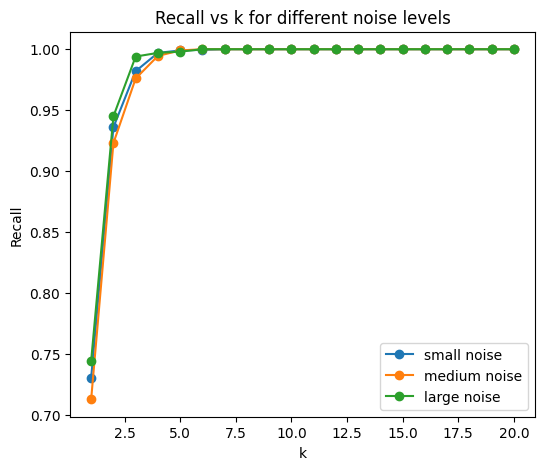

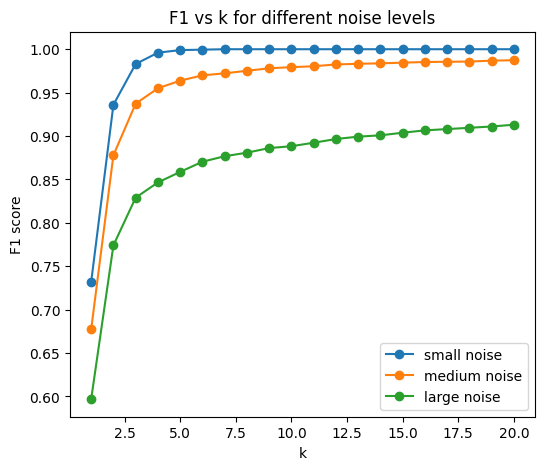

In [36]:
noise_levels = {
    "small noise" : noisy_small,
    "medium noise": noisy_medium,
    "large noise" : noisy_large,
}

ks = np.arange(1, 21)

results = {}

for name, x_noisy in noise_levels.items():
    precisions, recalls, f1s = [], [], []
    for k in ks:
        p, r, f1 = compute_prdc(x_real, x_noisy, k=k)
        precisions.append(p)
        recalls.append(r)
        f1s.append(f1)
    results[name] = {
        "precision": np.array(precisions),
        "recall": np.array(recalls),
        "f1": np.array(f1s),
    }

# Plot Precision
plt.figure(figsize=(6,5))
for name, vals in results.items():
    plt.plot(ks, vals["precision"], marker='o', label=name)
plt.xlabel("k")
plt.ylabel("Precision")
plt.title("Precision vs k for different noise levels")
plt.legend()
plt.show()

# Plot Recall
plt.figure(figsize=(6,5))
for name, vals in results.items():
    plt.plot(ks, vals["recall"], marker='o', label=name)
plt.xlabel("k")
plt.ylabel("Recall")
plt.title("Recall vs k for different noise levels")
plt.legend()
plt.show()

# Plot F1
plt.figure(figsize=(6,5))
for name, vals in results.items():
    plt.plot(ks, vals["f1"], marker='o', label=name)
plt.xlabel("k")
plt.ylabel("F1 score")
plt.title("F1 vs k for different noise levels")
plt.legend()
plt.show()

- precision:

  Small noise: Noisy points stay close to the real points.
  So precision is high because the noisy samples still look like the real data.

  Medium noise: Noisy points move a bit further away.
  So precision decreases since some noisy points are now off the real manifold.

  Large noise: Noisy points are spread everywhere.
  So precision becomes low, because many noisy samples no longer is close to the real data.

- Recall:

  Small noise: Noisy points are almost on the real samples. So it is easy to cover everything.

  Medium noise: Enough noisy points around. So recall stays high.

  Large noise: Noisy points spread widely but they still fall near the real points. So recall stays high.

  Recall does not decrease much because recall checks if real points are covered, not if noisy points are good. As long as some noisy samples stay near each region of the real distribution, recall remains high.

- F1 score:

  F1 goes down because precision falls.

  Small noise: Precision is high and recall is high. So F1 is very high.

  Medium noise: Precision is lower and recall is high. So F1 is lower.

  Large noise: Precision is low and recall is high. So F1 is the lowest.

**Q6**

In the definition of Maximum Mean Discrepancy (MMD) suppose that the kernel is linear. Derive a simplified expression for MMD in this case. Interpret this result.

The Maximum Mean Discrepancy (MMD) between two distributions P and Q with kernel k is defined as:

$$
\text{MMD}^2(P,Q;k)
= \left\| \mathbb{E}_{P}[\phi(X)] - \mathbb{E}_{Q}[\phi(Y)] \right\|_{H}^2
$$

The empirical version (biased estimator) is:

$$
\widehat{\text{MMD}}^2 =
\frac{1}{n^2}\sum_{i,j} k(x_i,x_j)
+ \frac{1}{m^2}\sum_{i,j} k(y_i,y_j)
- \frac{2}{nm}\sum_{i,j} k(x_i,y_j)
$$

-----

#### Linear Kernel

Let the kernel be linear:

$$
k(x,y) = x^\top y
$$

Plugg this into the formula:

$$
\widehat{\text{MMD}}^2 =
\frac{1}{n^2}\sum_{i,j} x_i^\top x_j
+ \frac{1}{m^2}\sum_{i,j} y_i^\top y_j
- \frac{2}{nm}\sum_{i,j} x_i^\top y_j
$$

So:

$$
\frac{1}{n^2}\sum_{i,j} x_i^\top x_j = \|\bar{x}\|^2,
\quad
\frac{1}{m^2}\sum_{i,j} y_i^\top y_j = \|\bar{y}\|^2,
\quad
\frac{1}{nm}\sum_{i,j} x_i^\top y_j = \bar{x}^\top \bar{y},
$$

where $ \bar{x} = \frac{1}{n}\sum_i x_i $ and $ \bar{y} = \frac{1}{m}\sum_j y_j $ are the sample means.

So:

$$
\widehat{\text{MMD}}^2
= \|\bar{x}\|^2 + \|\bar{y}\|^2 - 2\,\bar{x}^\top \bar{y}
= \|\bar{x} - \bar{y}\|^2
$$

and in expectation form:

$$
\text{MMD}^2(P,Q;k_{\text{linear}}) = \big\|\mathbb{E}_P[X] - \mathbb{E}_Q[Y]\big\|^2
$$

-----

### Interpretation

When we use a linear kernel MMD measures the distance between the means of the two distributions. So if the two datasets have the same mean MMD is equal to 0 even if their variances are very different. This means the linear kernel version of MMD only captures mean differences not full distributional differences.  
So in order to use the entire shape of the distributions, we use non-linear kernels.




**Q7**

Train two generative models in the following example of a S-shape dataset. Compare the results.










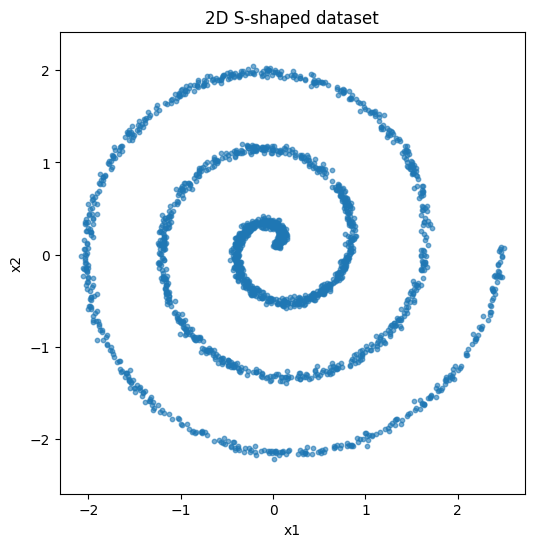

In [37]:
def sample_s_curve(n_samples=1000, noise=0.05, device="cpu"):
    """
    Generate a 2D S-shaped dataset.

    Parameters:
        n_samples (int): Number of samples
        noise (float): Standard deviation of Gaussian noise added
        device (str): "cpu" or "cuda"

    Returns:
        x: torch.Tensor of shape [n_samples, 2]
    """
    # Sample t uniformly from [0, 3*pi/2]
    t = torch.rand(n_samples, device=device) * 3 * torch.pi / 2
    x = torch.zeros(n_samples, 2, device=device)

    # S-curve coordinates
    x[:, 0] = t * torch.cos(4*t)      # x-axis
    x[:, 1] = t * torch.sin(4*t)      # y-axis

    # Add Gaussian noise
    x += torch.randn_like(x) * noise

    # Normalize (optional)
    x = (x - x.mean(dim=0)) / x.std(dim=0)

    return x

# --- Example: visualize the dataset ---
n_samples = 2000
x_scurve = sample_s_curve(n_samples=n_samples, noise=0.05)

plt.figure(figsize=(6,6))
plt.scatter(x_scurve[:,0].cpu(), x_scurve[:,1].cpu(), s=10, alpha=0.6)
plt.title("2D S-shaped dataset")
plt.xlabel("x1")
plt.ylabel("x2")
plt.axis("equal")
plt.show()

In [39]:
model_L = ScoreNet2D().to(device)
optimizer_L = optim.Adam(model_L.parameters(), lr=1e-3)

epochs = 3000
batch_size = 512
sigma = 0.2

losses_L = []
for epoch in range(epochs):
    x = sample_s_curve(batch_size).to(device)
    noise = torch.randn_like(x) * sigma
    x_tilde = x + noise
    target = - noise / (sigma**2)

    score_pred = model_L(x_tilde)
    loss = 0.5 * torch.mean((score_pred - target)**2)

    optimizer_L.zero_grad()
    loss.backward()
    optimizer_L.step()
    losses_L.append(loss.item())

    if (epoch+1) % 500 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss = {loss.item():.4f}")


Epoch 500/3000, Loss = 11.3378
Epoch 1000/3000, Loss = 11.7399
Epoch 1500/3000, Loss = 12.3339
Epoch 2000/3000, Loss = 10.6589
Epoch 2500/3000, Loss = 11.0609
Epoch 3000/3000, Loss = 11.4242


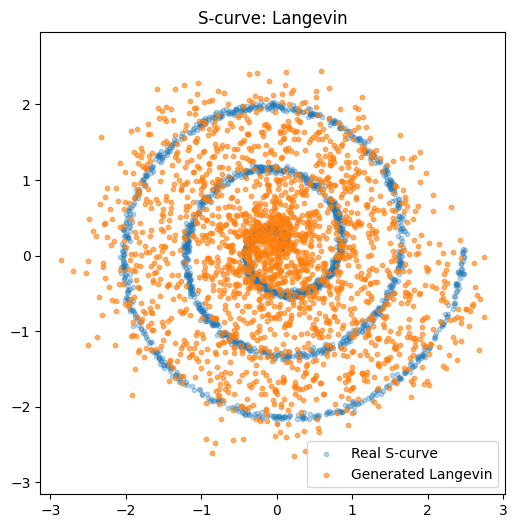

In [40]:
samples_L = langevin_sampling_2d(model_L, n_samples=2000, eps=0.02)

plt.figure(figsize=(6,6))
plt.scatter(x_scurve[:,0].cpu(), x_scurve[:,1].cpu(), s=10, alpha=0.3, label="Real S-curve")
plt.scatter(samples_L[:,0].cpu(), samples_L[:,1].cpu(), s=10, alpha=0.6, label="Generated Langevin")
plt.legend()
plt.axis("equal")
plt.title("S-curve: Langevin")
plt.show()


In [41]:
model_A = ScoreNetSigma().to(device)
optimizer_A = optim.Adam(model_A.parameters(), lr=1e-3)

In [42]:
sigmas_schedule = torch.exp(torch.linspace(torch.log(torch.tensor(1.0)), torch.log(torch.tensor(0.05)), 10)).to(device)

losses_A = []
for epoch in range(epochs):
    x = sample_s_curve(batch_size).to(device)

    idx = torch.randint(0, len(sigmas_schedule), (batch_size,), device=device)
    sigma_batch = sigmas_schedule[idx]
    noise = torch.randn_like(x) * sigma_batch.view(-1,1)
    x_tilde = x + noise
    target = - noise / (sigma_batch.view(-1,1)**2)

    score_pred = model_A(x_tilde, sigma_batch)
    loss = 0.5 * torch.mean((score_pred - target)**2)

    optimizer_A.zero_grad()
    loss.backward()
    optimizer_A.step()
    losses_A.append(loss.item())

    if (epoch+1) % 500 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss = {loss.item():.4f}")

Epoch 500/3000, Loss = 40.6236
Epoch 1000/3000, Loss = 42.6889
Epoch 1500/3000, Loss = 35.0770
Epoch 2000/3000, Loss = 39.3411
Epoch 2500/3000, Loss = 40.4510
Epoch 3000/3000, Loss = 36.6211


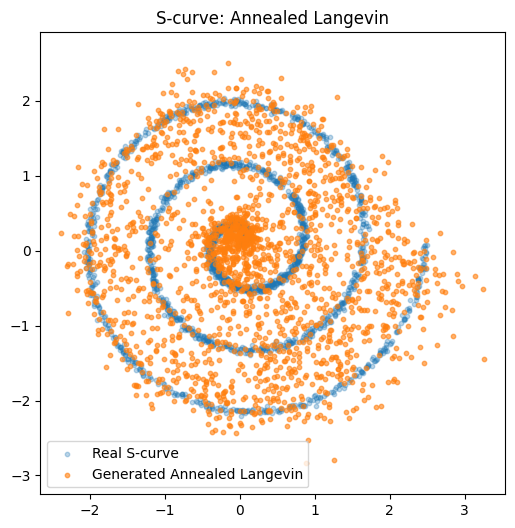

In [44]:
samples_A = langevin_sampling_annealed(model_A, n_samples=2000)

plt.figure(figsize=(6,6))
plt.scatter(x_scurve[:,0].cpu(), x_scurve[:,1].cpu(), s=10, alpha=0.3, label="Real S-curve")
plt.scatter(samples_A[:,0].cpu(), samples_A[:,1].cpu(), s=10, alpha=0.6, label="Generated Annealed Langevin")
plt.legend()
plt.axis("equal")
plt.title("S-curve: Annealed Langevin")
plt.show()

- Langevin Sampling:

  The model cannot follow the long spiral shape and points get stuck in high-density regions near the middle. Because a single noise level is too weak to explore such a complex shape.

- Annealed Langevin Sampling

  The generated samples cover the entire spiral much better. And the outer and inner loops are both captured. It is much better than Langevin because annealing starts with large noise, so it explores the full space and then slowly reduces noise.

In [48]:
x_real = x_scurve.detach().cpu().numpy()
samples_langevin  = samples_L.detach().cpu().numpy()
samples_annealed  = samples_A.detach().cpu().numpy()

kernel_sigmas = [0.1, 0.5, 1.0, 2.0]

for s in kernel_sigmas:
    mmd_l = mmd_gaussian(x_real, samples_langevin, sigma=s)
    mmd_a = mmd_gaussian(x_real, samples_annealed, sigma=s)
    print(f"sigma_k = {s:>3}:  Langevin = {mmd_l:.4f},  Annealed = {mmd_a:.4f}")

sigma_k = 0.1:  Langevin = 0.1022,  Annealed = 0.0956
sigma_k = 0.5:  Langevin = 0.0375,  Annealed = 0.0727
sigma_k = 1.0:  Langevin = 0.0199,  Annealed = 0.0839
sigma_k = 2.0:  Langevin = 0.0105,  Annealed = 0.0661


In [51]:
W_langevin = wasserstein_distance(x_real, samples_langevin)
W_annealed = wasserstein_distance(x_real, samples_annealed)

print("Wasserstein distance:")
print(f"Langevin vs data: {W_langevin:.4f}")
print(f"Annealed vs data: {W_annealed:.4f}")

Wasserstein distance:
Langevin vs data: 0.1949
Annealed vs data: 0.2546


In [52]:
ks = np.arange(1, 21)

metrics_langevin = {"precision": [], "recall": [], "f1": []}
metrics_annealed = {"precision": [], "recall": [], "f1": []}

for k in ks:
    p_l, r_l, f_l = compute_prdc(x_real, samples_langevin, k=k)
    p_a, r_a, f_a = compute_prdc(x_real, samples_annealed, k=k)

    metrics_langevin["precision"].append(p_l)
    metrics_langevin["recall"].append(r_l)
    metrics_langevin["f1"].append(f_l)

    metrics_annealed["precision"].append(p_a)
    metrics_annealed["recall"].append(r_a)
    metrics_annealed["f1"].append(f_a)

for key in metrics_langevin:
    metrics_langevin[key]  = np.array(metrics_langevin[key])
    metrics_annealed[key] = np.array(metrics_annealed[key])

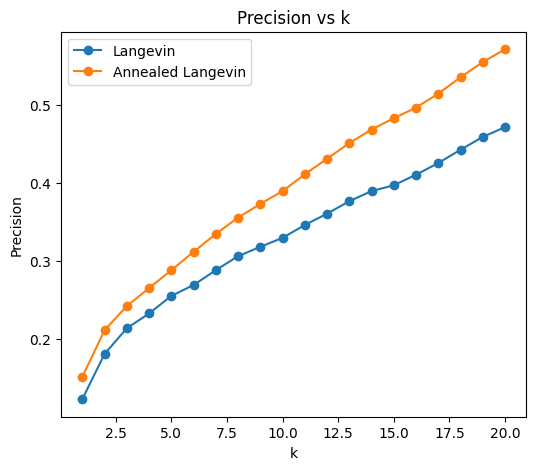

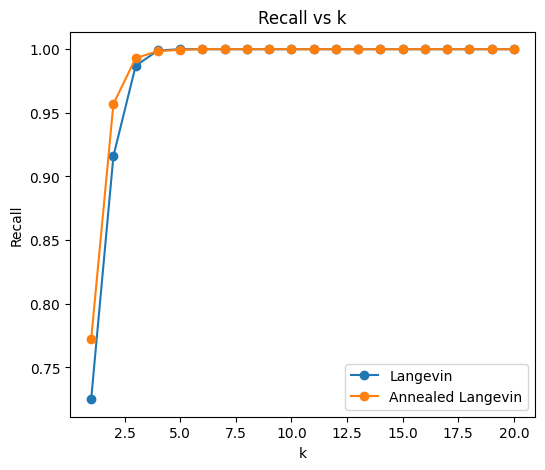

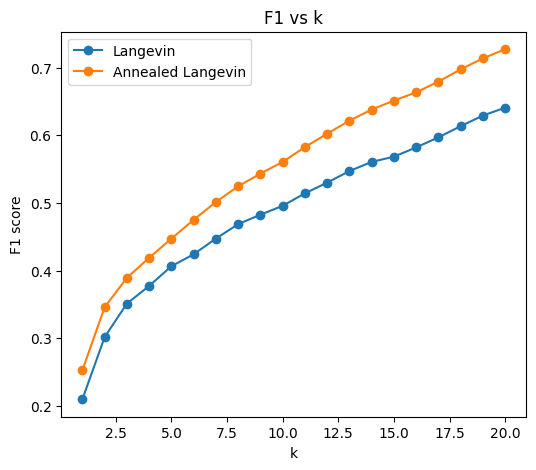

In [53]:
# Precision
plt.figure(figsize=(6,5))
plt.plot(ks, metrics_langevin["precision"], marker='o', label="Langevin")
plt.plot(ks, metrics_annealed["precision"], marker='o', label="Annealed Langevin")
plt.xlabel("k")
plt.ylabel("Precision")
plt.title("Precision vs k")
plt.legend()
plt.show()

# Recall
plt.figure(figsize=(6,5))
plt.plot(ks, metrics_langevin["recall"], marker='o', label="Langevin")
plt.plot(ks, metrics_annealed["recall"], marker='o', label="Annealed Langevin")
plt.xlabel("k")
plt.ylabel("Recall")
plt.title("Recall vs k")
plt.legend()
plt.show()

# F1
plt.figure(figsize=(6,5))
plt.plot(ks, metrics_langevin["f1"], marker='o', label="Langevin")
plt.plot(ks, metrics_annealed["f1"], marker='o', label="Annealed Langevin")
plt.xlabel("k")
plt.ylabel("F1 score")
plt.title("F1 vs k")
plt.legend()
plt.show()

Annealed Langevin does a much better job in the S-curve. But normal Langevin is too noisy and messy. Precision, Recall, and F1 score make this very clear. But MMD and Wasserstein get confused because Langevin spreads points everywhere, but visually and practically Annealed is clearly the better model.